# Stochastic Growth model solved with the Quantecon library

The normal stochastic growth model will be solved here using the quantecon library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
%matplotlib inline
import quantecon as qe
import time
from quantecon import compute_fixed_point
from quantecon.markov import DiscreteDP

In [2]:
start = time.time()

In [3]:
class SimpleOG:

    def __init__(self, kmin = 60, kmax=100, a_size = 500, z_size = 5, alpha=0.4, beta=0.99, gamma=0.5, delta=0.019, rho = 0.95, sigma = np.sqrt(0.000049)):
        """
        Set up R, Q and β, the three elements that define an instance of
        the DiscreteDP class.
        
        M is the upper limit of the storage capacity.
        """
        
        self.kmin, self.kmax = kmin, kmax 
        self.alpha, self.beta, self.gamma = alpha, beta, gamma 
        self.delta, self.rho, self.sigma = delta, rho, sigma
        self.sigmay = (sigma**2 / (1 - self.rho**2))**(1/2)
        
        self.a_size, self.z_size = a_size, z_size
        self.a_vals = np.linspace(self.kmin, self.kmax, a_size)
        self.mc = qe.markov.approximation.tauchen(self.rho, self.sigma, n = self.z_size)
        self.pi = self.mc.P
        self.z_vals = np.transpose(self.mc.state_values)
        if self.z_size == 1:
            self.z_vals[0] = 0
        
        # Setting up the asset grid
        self.n = self.a_size * self.z_size
        
        # Building the matrix R and Q:
        self.Q = np.zeros((self.n, self.a_size, self.n))
        self.populate_Q()
        
        self.R = np.zeros((self.n, self.a_size))
        self.populate_R()

    
    def populate_R(self):
        n = self.a_size * self.z_size
        self.c = np.zeros((n,self.a_size))
        for s_i in range(n):
            a_i = s_i // self.z_size         # Division without remainder
            z_i = s_i % self.z_size          # Remainder of the devision
            a = self.a_vals[a_i]
            z = self.z_vals[z_i]
            for new_a_i in range(self.a_size):
                w = np.exp(z)*(1-self.alpha)*a**(self.alpha)
                r = np.exp(z)*(self.alpha)*a**(self.alpha-1) - self.delta
                c = w + (1 + r) * a - self.a_vals[new_a_i]
                self.c[s_i, new_a_i] = c
                if c > 0:
                    if self.gamma != 1:
                        self.R[s_i, new_a_i] = (c**(1-1/self.gamma))/(1-1/self.gamma)  # Utility
                    else:
                        self.R[s_i, new_a_i] = np.log(c)
                else:
                    self.R[s_i, new_a_i] = -10000            # Setting the utility highly negative


    def populate_Q(self):
        n = self.a_size * self.z_size
        for s_i in range(n):
            z_i = s_i % self.z_size                    
            for a_i in range(self.a_size):
                for next_z_i in range(self.z_size):
                    self.Q[s_i, a_i, a_i * self.z_size + next_z_i] = self.pi[z_i, next_z_i]

In [4]:
# Setting up the parameters
an = 100
kmax = 91
kmin = 69
z_size = 21

g = SimpleOG(kmin = kmin, kmax = kmax, z_size = z_size, a_size = an)

Let’s create an instance using the objects stored in `g`

In [5]:
print(np.size(g.R), np.size(g.Q))

210000 441000000


In [6]:
ddp = qe.markov.DiscreteDP(g.R, g.Q, g.beta)

With the discrete dynamic problem instance, we now can solve it.

In [7]:
results = ddp.solve(method = "pi")

Check, whether the solutions converged.

In [8]:
results.num_iter

12

In [9]:
stop = time.time()
print("\nThe algorithm needed %F seconds to converge" % (stop-start))


The algorithm needed 121.556515 seconds to converge


Let's unravel the index.

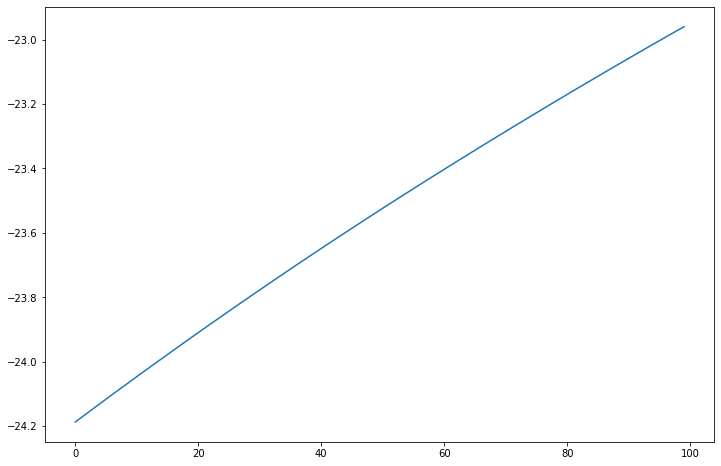

In [10]:
# Extracting the policy function
v = np.zeros((g.z_size, g.a_size))

n = g.z_size * g.a_size
for si in range(n):
    ai = si // g.z_size
    zi = si % g.z_size
    v[zi, ai] = results.v[si]

# Plotting the policy function
plt.subplots(figsize=(12,8))
num = int((g.z_size-1)/2)
plt.plot(v[num])
plt.show()

From the solutions we can extract the policy function, as well. Let us extract it, and unravel it.

In [11]:
# Extracting the policy function
sigma = results.sigma
sigma = sigma.reshape((g.z_size, g.a_size))

policy = np.empty((g.z_size, g.a_size))
policy1 = np.copy(policy)
n = g.z_size * g.a_size
for si in range(n):
    ai = si // g.z_size
    zi = si % g.z_size
    policy[zi, ai] = g.a_vals[results.sigma[si]]
    policy1[zi, ai] = results.sigma[si]

# Generating a capital grid
t = np.linspace(kmin,kmax,an)

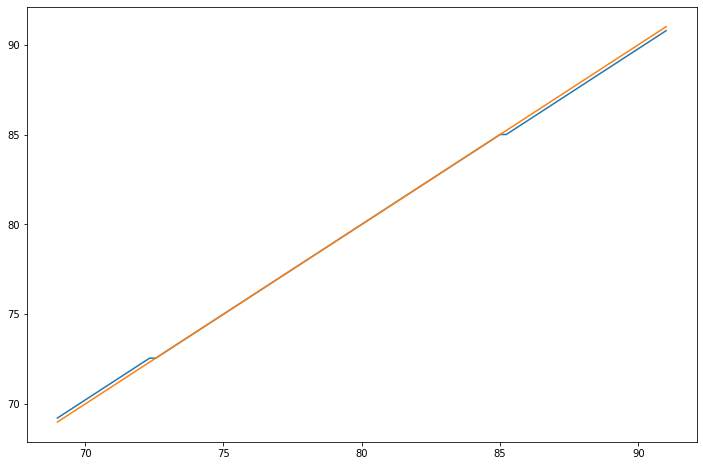

In [12]:
# Interpolate the policy function
t = np.linspace(kmin, kmax, an)
tck = interp.splrep(t, policy[num,:], k = 3)
y_app_spl = lambda x: interp.splev(x, tck)
excess = lambda x: y_app_spl(x) - x

# Plotting the relations
plt.subplots(figsize=(12,8))
plt.plot(t, y_app_spl(t))
plt.plot(t,t)
plt.show()

Let's plot all the policy functions. We find that all of them at some points cross the vertical line, implying that no dynamic is divergent.

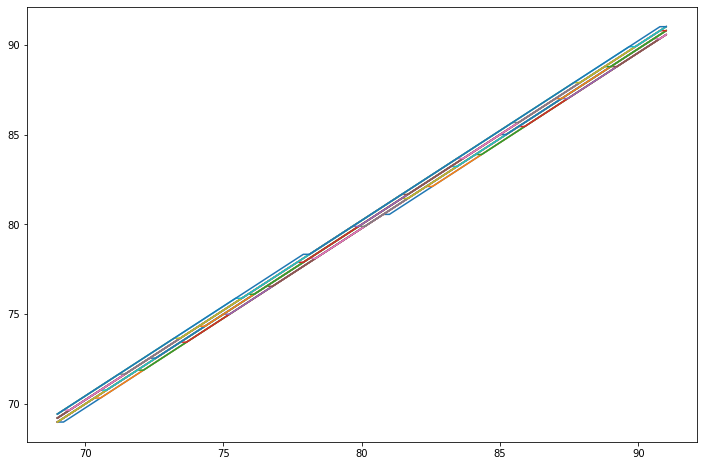

In [13]:
# Plot all policy functions together
plt.subplots(figsize=(12,8))
plt.plot(t, np.transpose(policy))
plt.show()

Next, let's get the policy function for consumption.

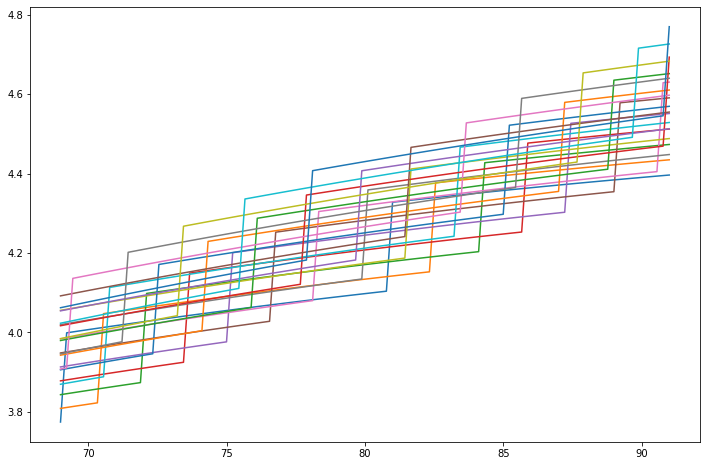

In [14]:
# Getting the policy function for consumption
polcon = np.zeros((g.z_size, g.a_size))
for i, s in enumerate(g.z_vals):
    for j, k in enumerate(g.a_vals):
        polcon[i,j] = np.exp(s)*k**g.alpha - policy[i,j] + (1-g.delta)*k

        
# Plotting the policy function for consumption
plt.subplots(figsize=(12,8))
plt.plot(g.a_vals,np.transpose(polcon))
plt.show()

Let's now simulate the economy with some development:

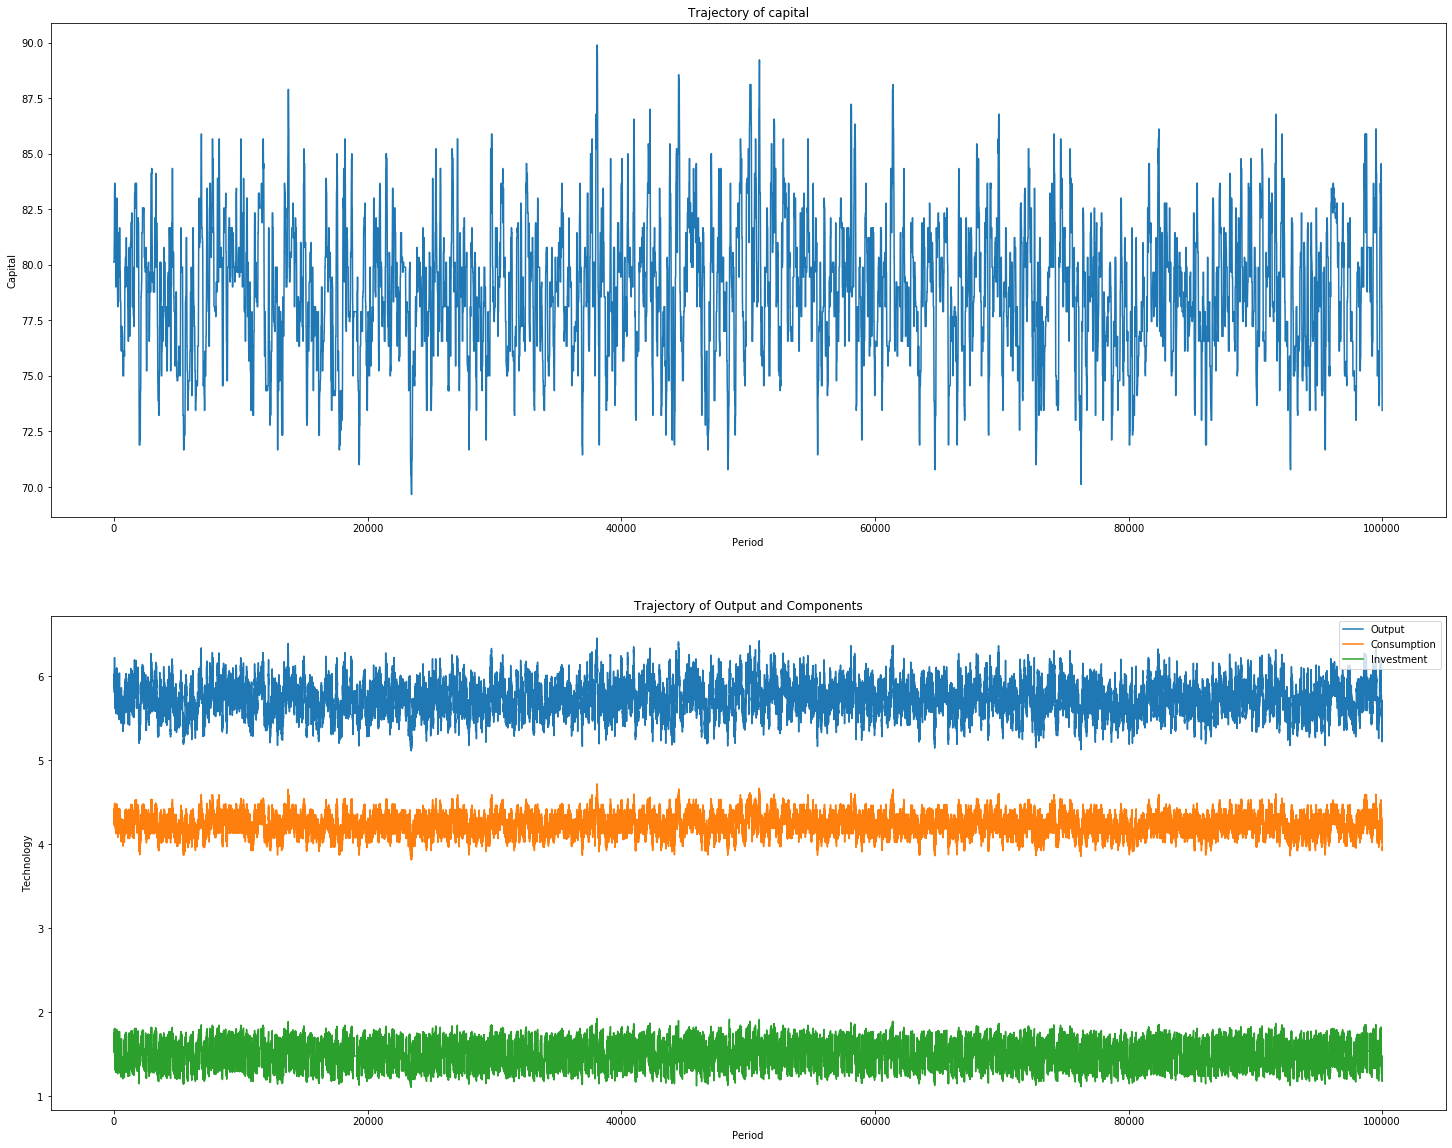

In [15]:
# Setting up arrays to store the results
T = 100000
cap0 = (kmax-kmin)/2 + kmin
index = int(an/(kmax-kmin)*(cap0-kmin))*g.z_size

# Simulating the time path
mc = qe.MarkovChain(g.pi, state_values=np.arange(g.z_size))
a_dev = mc.simulate(ts_length=T, init= int((g.z_size+1)/2))

cap1 = np.zeros((T))
cap = np.copy(cap1)
cap1[0] = int(index/g.z_size)
cap[0] = g.a_vals[int(cap1[0])]  

# Simulate the economy
for t in range(1,T):
    cap1[t] = policy1[int(a_dev[t-1]), int(cap1[t-1])]
    cap[t] = g.a_vals[int(cap1[t])]

out = np.exp(g.z_vals[a_dev])*cap**g.alpha
cons = out - policy[np.int16(a_dev), np.int16(cap1)] + (1-g.delta)*cap
inv = out - cons

# Plotting the development
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(25,20))
axes[0].plot(cap)
axes[0].set_title("Trajectory of capital")
axes[0].set_xlabel("Period")
axes[0].set_ylabel("Capital")

axes[1].plot(out, label = "Output")
axes[1].plot(cons, label = "Consumption")
axes[1].plot(inv, label = "Investment")
axes[1].set_title("Trajectory of Output and Components")
axes[1].legend(loc=1)
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Technology")
plt.show()

We now can check for the stochastic steady states.

In [16]:
print("\nThe mean of capital, consumption, output, and investments are %.5F, %.5F, %.5F, and %.5F." % (np.mean(cap), np.mean(cons), np.mean(out), np.mean(inv)))


The mean of capital, consumption, output, and investments are 78.80588, 4.23712, 5.73437, and 1.49725.


Although we cannot recover the steady state via the root finding algorithm, we see that from the simulation, we fluctuate around the steady state.

In [17]:
print("\nThe variability of output, consumption, and investment are %.5F, %.5F, and %.5F." % (np.std(out)*100/np.mean(out),np.std(cons)*100/np.mean(cons),np.std(inv)*100/np.mean(inv)))


The variability of output, consumption, and investment are 3.32329, 2.80036, and 8.01999.


When we extract the variability of the variables over time, we find that the ordering of the variables is actually correct, as we observe them in reality.

In [18]:
# Computation of the correlation with output
corr1 = np.corrcoef(out,cons)[0,1]
corr2 = np.corrcoef(out,inv)[0,1]
print("\nThe correlation of consumption and investment with output are %.5F, and %.5F." % (corr1, corr2))


The correlation of consumption and investment with output are 0.79553, and 0.80095.


So the model manages to replicate well certain moments of the data. However, the correlation between consumption and investment with output is too high. Therefore, we need to include additional transmission mechanisms. For this, we turn to the RBC, next.